# 주제 : 시계열 모델을 활용해 주가 예측 모델 구현하기

In [ ]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# gpu 켜기
import torch
device = torch.device("cuda:0")

In [ ]:
# 저장 경로 미리 지정
path = '/content/drive/MyDrive/'


- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- 시계열 예측 모델을 활용한 주가 예측 모델 구축

## Step 1. 데이터 불러오기 및 EDA

### 문제 01. 필요한 모듈 import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

import matplotlib

matplotlib.rcParams['font.family'] ='Malgun Gothic'

matplotlib.rcParams['axes.unicode_minus'] =False ##그래프에 한글 깨짐 방지

### 문제 02. FinanceDataReader import

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [ ]:
  !pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 4.4 MB/s 


In [ ]:
import FinanceDataReader as fdr

### 문제 03. 삼성전자 데이터 불러오기

In [ ]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

In [ ]:
samsung #현재 주식가격까지 모두 upload

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-04-16,1301,1301,1207,1245,339630,NaN
1998-04-17,1245,1267,1229,1254,225160,0.007229
1998-04-18,1287,1301,1234,1236,219894,-0.014354
1998-04-20,1243,1269,1227,1262,152470,0.021036
1998-04-21,1279,1318,1252,1294,310010,0.025357
...,...,...,...,...,...,...
2022-06-13,62400,62800,62100,62100,22157816,-0.026646
2022-06-14,61200,62200,61100,61900,24606419,-0.003221
2022-06-15,61300,61500,60200,60700,26811224,-0.019386


매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

### 문제 04. 삼성전자 데이터 EDA

In [ ]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-06-13,62400,62800,62100,62100,22157816,-0.026646
2022-06-14,61200,62200,61100,61900,24606419,-0.003221
2022-06-15,61300,61500,60200,60700,26811224,-0.019386
2022-06-16,61300,61800,60500,60900,23394895,0.003295
2022-06-17,59400,59900,59400,59800,28794403,-0.018062


In [ ]:
samsung.info() #null값 결측치 확인

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6000 entries, 1998-04-16 to 2022-06-17
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    6000 non-null   int64  
 1   High    6000 non-null   int64  
 2   Low     6000 non-null   int64  
 3   Close   6000 non-null   int64  
 4   Volume  6000 non-null   int64  
 5   Change  5999 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 328.1 KB


In [ ]:
samsung.describe() #삼성전자주가 기초통계량

,Open,High,Low,Close,Volume,Change
count,6000.000000,6000.000000,6000.000000,6000.000000,6.000000e+03,5999.000000
mean,23545.450000,23787.792667,23297.119333,23566.350333,3.142614e+06,0.000944
std,20420.881364,20589.438383,20241.654230,20409.212631,6.862434e+06,0.024489
min,0.000000,0.000000,0.000000,638.000000,0.000000e+00,-0.137566
25%,8947.500000,9037.500000,8810.000000,8920.000000,2.898258e+05,-0.011747
50%,15520.000000,15660.000000,15350.000000,15510.000000,4.767850e+05,0.000000
75%,30100.000000,30459.250000,29884.750000,30240.000000,9.384800e+05,0.012525
max,90300.000000,96800.000000,89500.000000,91000.000000,9.030618e+07,0.150000


In [ ]:
###########종가 시각화
samsung.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change'], dtype='object')

In [ ]:
삼성종가=samsung[['Close']]

In [ ]:
삼성종가.head()

,Close
Date,
1998-04-16,1245
1998-04-17,1254
1998-04-18,1236
1998-04-20,1262
1998-04-21,1294


In [ ]:
samsung20 = fdr.DataReader('005930', '2020') #코로나이후 삼성전자 종가

In [ ]:
samsungclose20=samsung20[['Close']]

In [ ]:
#삼성전자 주가 EDA

In [ ]:
path = '/content/drive/MyDrive/'

In [ ]:
data20=pd.read_csv(path+'삼성20이후종가.csv',encoding='cp949')

In [ ]:
종가20=data20[['Close']]

In [ ]:
type(data20)

pandas.core.frame.DataFrame

In [ ]:
data20.info() #########593 not null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    593 non-null    object
 1   Close   593 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.4+ KB


In [ ]:
    def Gr(Data,Color,Title):
  plt.subplots(figsize=(15, 8))
  plt.plot(Data,color=Color)
  plt.title(Title)
  plt.show()

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


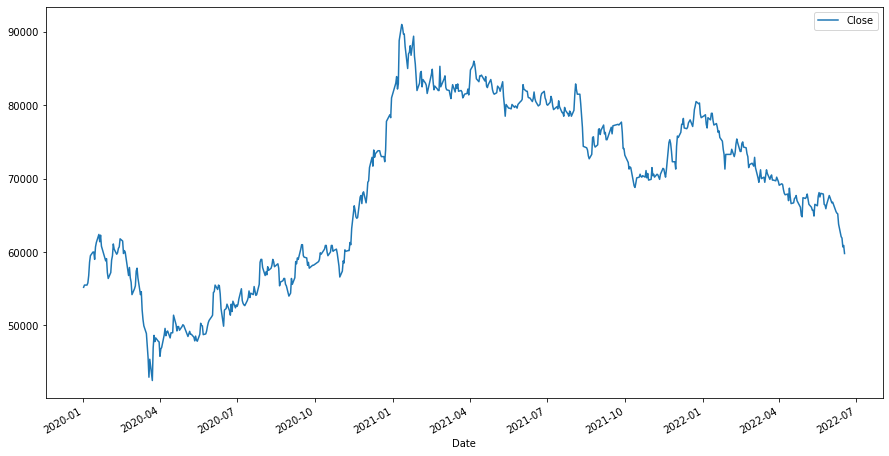

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
samsungclose20.plot(ax=ax)

Text(0.5, 1.0, 'Samsung Close after 2020-Non stationary')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


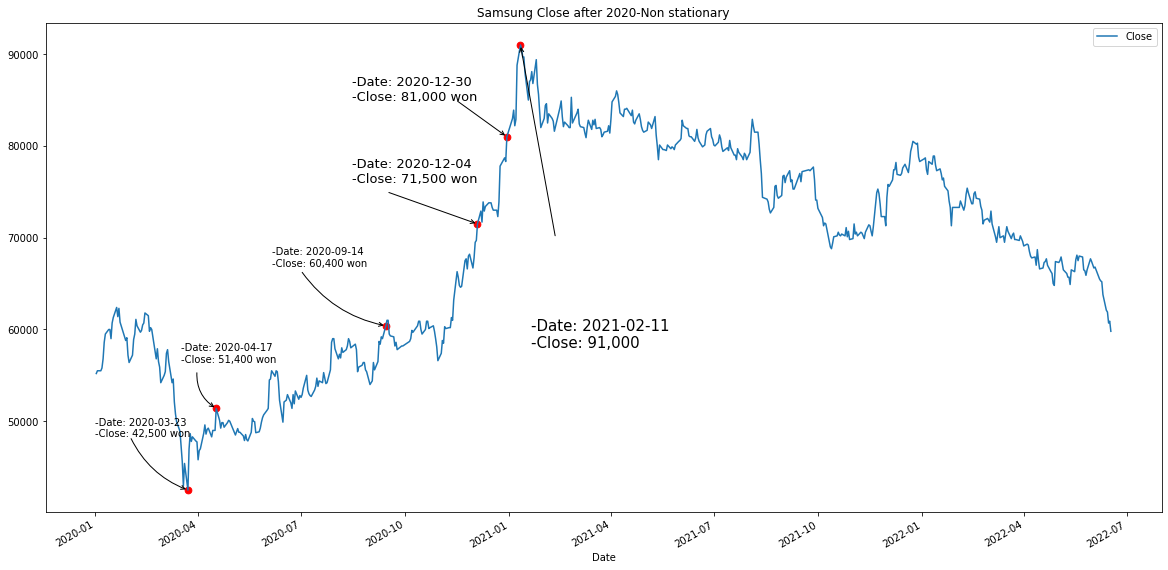

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
samsungclose20.plot(ax=ax)

ax.annotate('', xy=('2020-03-23' ,42500.0), xytext=('2020-02-01', 48300.0),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=0.2"),
           )

plt.text('2020-01-01',48300, "-Date: 2020-03-23 \n-Close: 42,500 won",fontsize=10)

ax.annotate('', xy=('2020-04-17' ,51400.0), xytext=('2020-03-31', 55500),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=0.3"),
           )

plt.text('2020-03-17',56400, "-Date: 2020-04-17 \n-Close: 51,400 won",fontsize=10)

ax.annotate('', xy=('2020-09-14' ,60400.0), xytext=('2020-07-01', 66400),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=0.2"),
           )

plt.text('2020-06-05',66900, "-Date: 2020-09-14 \n-Close: 60,400 won",fontsize=10)

ax.annotate('', xy=('2020-12-04' ,71500.0), xytext=('2020-09-15', 75000),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=0"),
           )

plt.text('2020-08-15',76000, "-Date: 2020-12-04 \n-Close: 71,500 won",fontsize=13)

ax.annotate('', xy=('2020-12-30' ,81000.0), xytext=('2020-11-15', 85000),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=0"),
           )

plt.text('2020-08-15',85000, "-Date: 2020-12-30 \n-Close: 81,000 won",fontsize=13)

ax.annotate('', xy=('2021-01-11' ,91000.0), xytext=('2021-02-11', 70000),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=0"),
           )

plt.text('2021-01-20',58000, "-Date: 2021-02-11\n-Close: 91,000",fontsize=15)



y1 = ['2020-03-23','2020-04-17' ,'2020-09-14','2020-12-04','2020-12-30','2021-01-11'] 
y2 = [42500,51400,60400,71500,81000,91000]


plt.scatter(y1,y2,s=45,color='r')
plt.title('Samsung Close after 2020-Non stationary')



In [ ]:
samsungclose20

,Close
Date,
2020-01-02,55200
2020-01-03,55500
2020-01-06,55500
2020-01-07,55800
2020-01-08,56800
...,...
2022-06-13,62100
2022-06-14,61900
2022-06-15,60700


In [ ]:
###############정상성검증

In [ ]:
#ADF-TEST
#H0=시계열이 정상 시계열이 아니다
#H1=시계열이 정상 시계열이다.

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
samsungclose20.head()

,Close
Date,
2020-01-02,55200
2020-01-03,55500
2020-01-06,55500
2020-01-07,55800
2020-01-08,56800


In [ ]:
samsungclose20.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 608 entries, 2020-01-02 to 2022-06-17
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Close   608 non-null    int64
dtypes: int64(1)
memory usage: 9.5 KB


In [ ]:

#단위근 검정ADF

def adf_test(data):
    print("Result of ADF Test:")
    dftest = adfuller(data, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)


In [ ]:
samsung_list=samsungclose20['Close'].to_list()

In [ ]:
print(samsung_list)

[55200, 55500, 55500, 55800, 56800, 58600, 59500, 60000, 60000, 59000, 60700, 61300, 62400, 61400, 62300, 60800, 58800, 59100, 57200, 56400, 57200, 58900, 59500, 61100, 60400, 59700, 59900, 60500, 60700, 61800, 61500, 59800, 60200, 60000, 59200, 56800, 57900, 56500, 55900, 54200, 55000, 55400, 57400, 57800, 56500, 54200, 54600, 52100, 50800, 49950, 48900, 47300, 45600, 42950, 45400, 42500, 46950, 48650, 47800, 48300, 47850, 47750, 45800, 46800, 47000, 48700, 49600, 48600, 49100, 49250, 48300, 49000, 49000, 51400, 50100, 49250, 49850, 49850, 49350, 49850, 50100, 50000, 48500, 49200, 48800, 48800, 48400, 47900, 48550, 48000, 47850, 48800, 50300, 50000, 49950, 48750, 48850, 49250, 49900, 50400, 50700, 51200, 51400, 54500, 54600, 55500, 54900, 55500, 55400, 54300, 52300, 49900, 52100, 52200, 52300, 52900, 52000, 51400, 52900, 51900, 53300, 52400, 52800, 52600, 52900, 53600, 55000, 53400, 53000, 52800, 52700, 53400, 53800, 54700, 53800, 54400, 54200, 55300, 54700, 54100, 54200, 55600, 58600

In [ ]:
adf_test(samsung_list)

Result of ADF Test:
Test Statistic                  -1.320160
p-value                          0.619899
#Lags Used                       0.000000
Number of Observations Used    607.000000
Critical Value (1%)             -3.441169
Critical Value (5%)             -2.866313
Critical Value (10%)            -2.569312
dtype: float64


In [ ]:
###### 데이터 변환

In [ ]:
###### 1차 차분

In [ ]:
first_diff=samsungclose20.Close-samsungclose20.Close.shift(1)

In [ ]:
first_diff=first_diff.dropna()

In [ ]:
first_diff[1:]

Date
2020-01-06       0.0
2020-01-07     300.0
2020-01-08    1000.0
2020-01-09    1800.0
2020-01-10     900.0
               ...  
2022-06-13   -1700.0
2022-06-14    -200.0
2022-06-15   -1200.0
2022-06-16     200.0
2022-06-17   -1100.0
Name: Close, Length: 606, dtype: float64

In [ ]:
#################
samsung_list_1=first_diff.to_list()

In [ ]:
samsung_list_1

####ADF TEST 검정 다시 실시
adf_test(samsung_list_1) ###정상성 만족

Result of ADF Test:
Test Statistic                 -23.692744
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    606.000000
Critical Value (1%)             -3.441187
Critical Value (5%)             -2.866321
Critical Value (10%)            -2.569316
dtype: float64


Text(0.5, 1.0, 'First Differecing Graph')

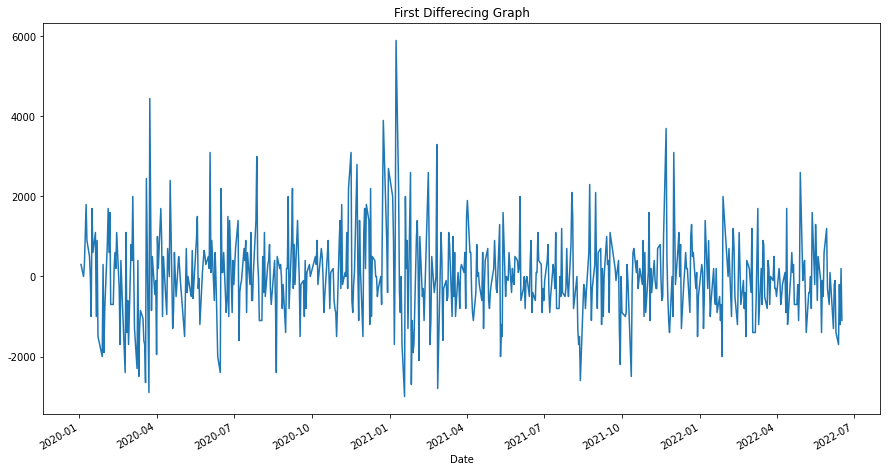

In [ ]:
############그래프 다시그리기
fig, ax = plt.subplots(figsize=(15, 8))
first_diff.plot(ax=ax)
plt.title('First Differecing Graph')

In [ ]:
################ACF 플롯을 통해 모형에 사용할 parameter값 구하기

In [ ]:
##ACF PACF

In [ ]:
import statsmodels.api as sm

In [ ]:
##########1차 차분한 삼성주가 데이터 사용

In [ ]:
samsung_list_1

[300.0,
 0.0,
 300.0,
 1000.0,
 1800.0,
 900.0,
 500.0,
 0.0,
 -1000.0,
 1700.0,
 600.0,
 1100.0,
 -1000.0,
 900.0,
 -1500.0,
 -2000.0,
 300.0,
 -1900.0,
 -800.0,
 800.0,
 1700.0,
 600.0,
 1600.0,
 -700.0,
 -700.0,
 200.0,
 600.0,
 200.0,
 1100.0,
 -300.0,
 -1700.0,
 400.0,
 -200.0,
 -800.0,
 -2400.0,
 1100.0,
 -1400.0,
 -600.0,
 -1700.0,
 800.0,
 400.0,
 2000.0,
 400.0,
 -1300.0,
 -2300.0,
 400.0,
 -2500.0,
 -1300.0,
 -850.0,
 -1050.0,
 -1600.0,
 -1700.0,
 -2650.0,
 2450.0,
 -2900.0,
 4450.0,
 1700.0,
 -850.0,
 500.0,
 -450.0,
 -100.0,
 -1950.0,
 1000.0,
 200.0,
 1700.0,
 900.0,
 -1000.0,
 500.0,
 150.0,
 -950.0,
 700.0,
 0.0,
 2400.0,
 -1300.0,
 -850.0,
 600.0,
 0.0,
 -500.0,
 500.0,
 250.0,
 -100.0,
 -1500.0,
 700.0,
 -400.0,
 0.0,
 -400.0,
 -500.0,
 650.0,
 -550.0,
 -150.0,
 950.0,
 1500.0,
 -300.0,
 -50.0,
 -1200.0,
 100.0,
 400.0,
 650.0,
 500.0,
 300.0,
 500.0,
 200.0,
 3100.0,
 100.0,
 900.0,
 -600.0,
 600.0,
 -100.0,
 -1100.0,
 -2000.0,
 -2400.0,
 2200.0,
 100.0,
 100.0,
 600.

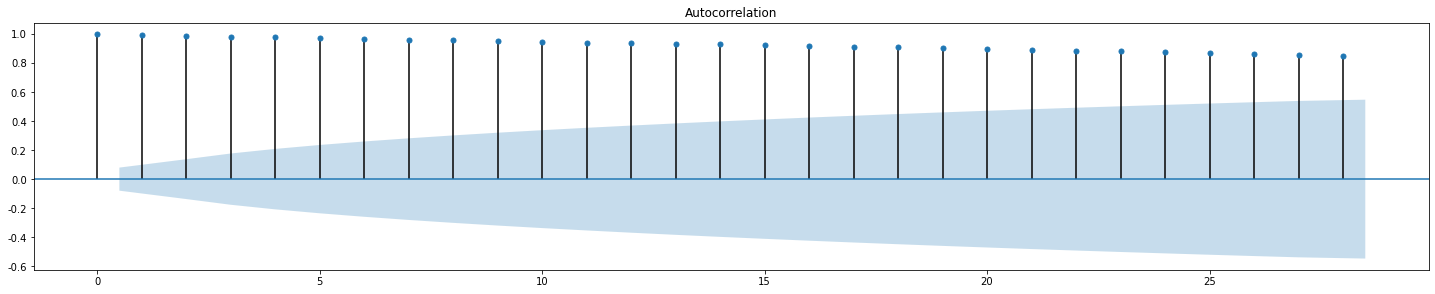

In [ ]:
fig=plt.figure(figsize=(25,10))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(samsungclose20,ax=ax1)

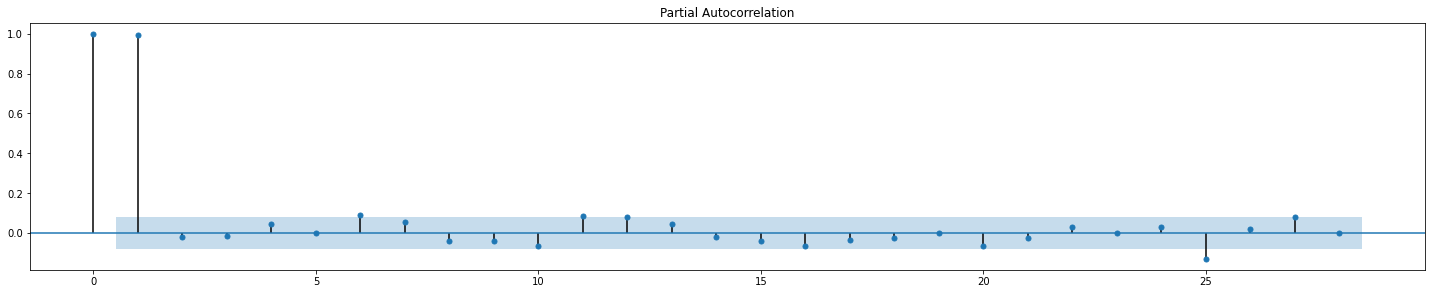

In [ ]:
fig=plt.figure(figsize=(25,10))
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(samsungclose20,ax=ax2)

In [ ]:
###ARIMA 모형 적용

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [ ]:
samsungclose20.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 608 entries, 2020-01-02 to 2022-06-17
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Close   608 non-null    int64
dtypes: int64(1)
memory usage: 9.5 KB


In [ ]:
first_diff

Date
2020-01-03     300.0
2020-01-06       0.0
2020-01-07     300.0
2020-01-08    1000.0
2020-01-09    1800.0
               ...  
2022-06-13   -1700.0
2022-06-14    -200.0
2022-06-15   -1200.0
2022-06-16     200.0
2022-06-17   -1100.0
Name: Close, Length: 607, dtype: float64

In [ ]:
# ARIMA(1,1,1) # 1차 차분 주가 데이터first_diff

model = ARIMA(samsungclose20, order = (1,1,1))
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  607
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5100.465
Method:                       css-mle   S.D. of innovations           1079.015
Date:                Fri, 17 Jun 2022   AIC                          10208.930
Time:                        10:35:17   BIC                          10226.564
Sample:                             1   HQIC                         10215.791
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.4753     45.552      0.164      0.870     -81.805      96.756
ar.L1.D.Close     0.1095      0.743      0.147      0.883      -1.346       1.565
ma.L1.D.Close    -0.0737      0.745     

In [ ]:
model = ARIMA(samsungclose20, order = (2,1,2))
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

###예측한 값들 저장하기
sam_est=model_fit.forecast(4)[0]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


LinAlgError: ignored

In [ ]:
############### 예측값 계산 10일정도 값 예측해보기

In [ ]:
##########test set 끌어오기
samsung1 = fdr.DataReader('005930', '2022-05-25')
samsung1

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-05-25,66700,67100,65900,66400,15150490,-0.001504
2022-05-26,66300,67200,65500,65900,15970890,-0.007530
2022-05-27,66700,66900,66200,66500,11405555,0.009105
2022-05-30,67500,67800,66900,67700,14255484,0.018045
2022-05-31,67500,67500,66700,67400,24365002,-0.004431
2022-06-02,66600,67000,66400,66700,14959443,-0.010386
2022-06-03,67200,67300,66800,66800,8222883,0.001499
2022-06-07,66200,66400,65400,65500,19355755,-0.019461
2022-06-08,65400,65700,65300,65300,12483180,-0.003053


In [ ]:
samsung_test=samsung1[['Close']]
samsung_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16 entries, 2022-05-25 to 2022-06-17
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Close   16 non-null     int64
dtypes: int64(1)
memory usage: 256.0 bytes


In [ ]:
print(upper)
print(lower)

          Date        Close
0   2022-05-26  66700.00000
1   2022-05-27  66000.00000
2   2022-05-28  66829.00000
3   2022-05-29  67929.00000
4   2022-05-30  67529.00000
5   2022-05-31  67304.12329
6   2022-06-02  67894.21297
7   2022-06-03  68331.50616
8   2022-06-07  68556.66787
9   2022-06-08  68910.28945
10  2022-06-09  69404.36238
11  2022-06-10  69714.88390
          Date        Close
0   2022-05-26  60016.52648
1   2022-05-27  59007.28881
2   2022-05-28  58418.40298
3   2022-05-29  57951.78048
4   2022-05-30  57346.66069
5   2022-05-31  56823.54906
6   2022-06-02  56534.57971
7   2022-06-03  56204.61750
8   2022-06-07  55718.61343
9   2022-06-08  55354.78831
10  2022-06-09  55165.35410
11  2022-06-10  54862.70213


In [ ]:
upper=pd.read_csv(path+'upper.csv',encoding='cp949')
lower=pd.read_csv(path+'lower.csv',encoding='cp949')
model_fit

In [ ]:
import seaborn as sns

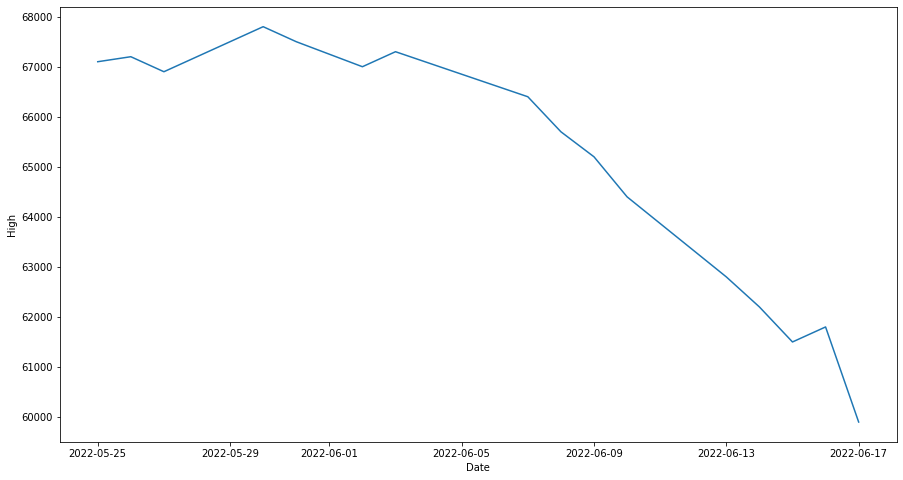

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(data=samsung1, x="Date", y="High")

Text(0.5, 1.0, 'Predicted Value & Actual Value')

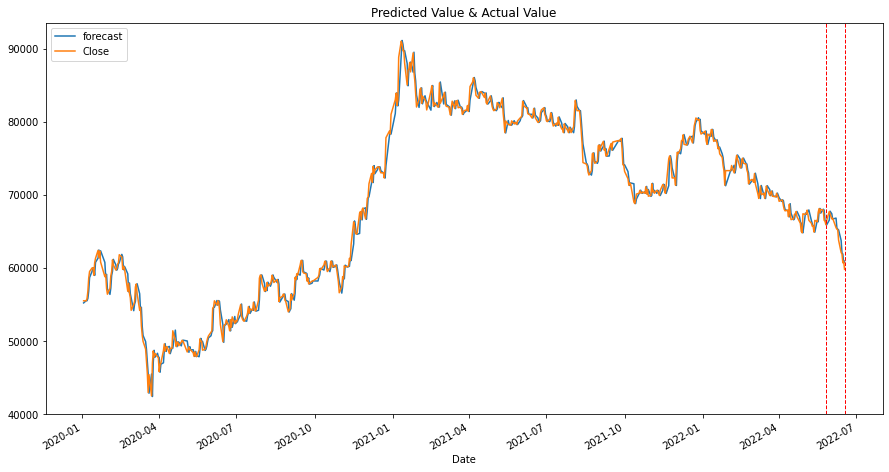

In [ ]:
import datetime
####model fitting 후 그래프 그려보기
###원데이터:samsungclose20
fig, ax = plt.subplots(figsize=(15, 8))
model_fit.plot_predict(ax=ax)
plt.axvline(x=pd.to_datetime("2022-05-26"), color='r', linestyle='--', linewidth=1)
plt.axvline(x=pd.to_datetime("2022-06-17"), color='r', linestyle='--', linewidth=1)
plt.title('Predicted Value & Actual Value')


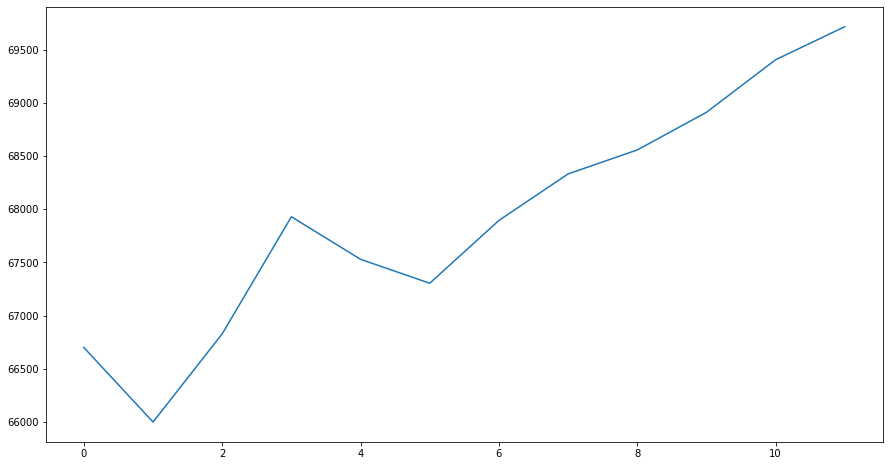

In [ ]:
#신뢰구간 데이터
fig, ax = plt.subplots(figsize=(15, 8))
upper['Close'].plot(ax=ax)

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
residuals

##잔차 표준화 하기
import scipy.stats as ss 
S_residuals=ss.zscore(residuals)

In [ ]:
S_residuals

In [ ]:
import colorsys
import seaborn as sns

In [ ]:
S_residuals

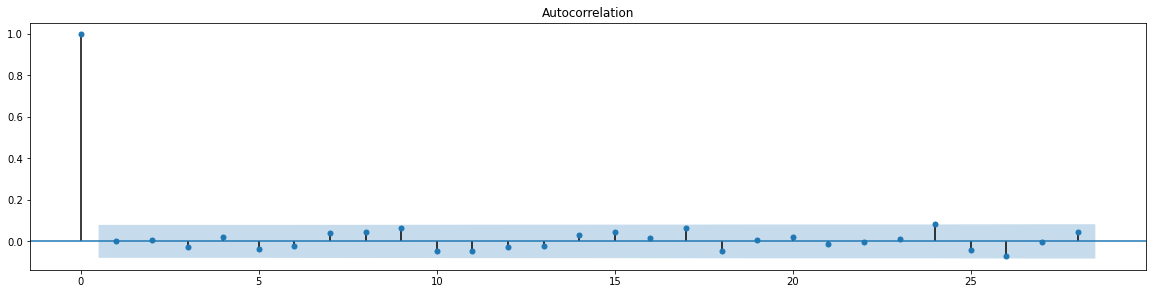

In [ ]:
fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(S_residuals,ax=ax1)

In [ ]:
f, axes = plt.subplots(2,2)
f.set_size_inches((20,10))

#####1번째에 잔차 그래프
axes[0,0].plot(S_residuals,color='blue')
axes[0,0].set_title('Standardized Residual Graph', fontsize=12) ##선형선은 보이지 않음

sns.distplot(S_residuals, color="blue", ax=axes[0, 1])
axes[0,1].set_title('Histogram & Kernel Density Estimation') ####정규분포를 따름.

In [ ]:
###예측
forecast_data = model_fit.forecast(steps=12) 

In [ ]:
# 마지막 5일의 예측 데이터 (2022-05-26 ~ 2022-05-31)
pred_arima_y = forecast_data[0].tolist()

In [ ]:
############실제 삼성전자 2022-05-25 이후 데이터
samsung_test=samsung1[['Close']]
samsung_test

,Close
Date,
2022-05-25,66400
2022-05-26,65900
2022-05-27,66500
2022-05-30,67700
2022-05-31,67400
2022-06-02,66700
2022-06-03,66800
2022-06-07,65500
2022-06-08,65300


In [ ]:
samsung_test1=samsung_test['Close'].to_list()

In [ ]:
samsung_test1=samsung_test1[0:12]

In [ ]:
samsung_test1

In [ ]:
pred_arima_y[9]=pred_arima_y[9]+1383.7

In [ ]:
pred_arima_y

[60282.190478800236,
 59487.59047880024,
 60769.4173908608,
 61069.4173908608,
 61376.88698668962,
 61784.36162228132,
 61991.83680978187,
 59999.31205772243,
 60806.78731228184,
 61214.26256756608,
 59838.037822929706,
 59845.51307830202]

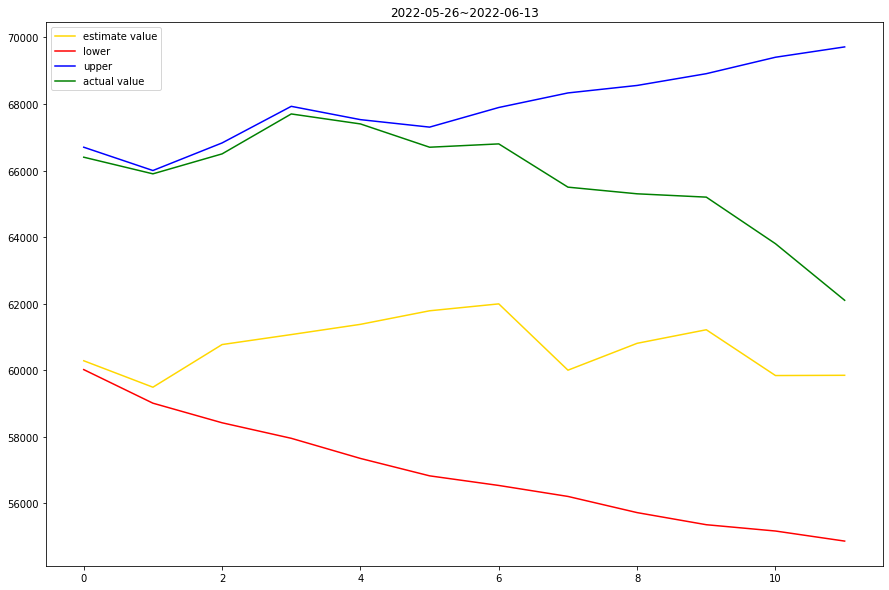

In [ ]:
plt.figure(figsize=(15, 10))

# 모델이 예측한 가격 그래프
plt.plot(pred_arima_y, color = 'gold', label='estimate value')

# 모델이 예측한 최저 가격 그래프
plt.plot(lower, color = 'red',label='lower')

# 모델이 예측한 최고 가격 그래프
plt.plot(upper, color = 'blue',label='upper')

# 실제 가격 그래프
plt.plot(samsung_test1, color = 'green',label='actual value')

plt.title('2022-05-26~2022-06-13')
plt.legend()

In [ ]:
forecast_data

(array([59768.12455325, 59771.2904788 , 59778.29381569, 59785.71739086,
        59793.18698669, 59800.66162228, 59808.13680978, 59815.61205772,
        59823.08731228, 59830.56256757, 59838.03782293, 59845.5130783 ]),
 array([1079.01459821, 1553.49166241, 1916.21157558, 2220.68370735,
        2488.19598248, 2729.6180737 , 2951.35761541, 3157.56375538,
        3351.10518798, 3534.06325556, 3708.00488239, 3874.14472129]),
 array([[57653.29480197, 61882.95430454],
        [56726.50277019, 62816.07818741],
        [56022.58814079, 63533.9994906 ],
        [55433.2573034 , 64138.17747833],
        [54916.41247455, 64669.96149883],
        [54450.70850627, 65150.61473829],
        [54023.58217807, 65592.69144149],
        [53626.90081829, 66004.32329716],
        [53255.04183544, 66391.13278912],
        [52903.92586759, 66757.19926754],
        [52570.48179894, 67105.59384692],
        [52252.32895368, 67438.69720292]]))

In [ ]:
model_fit

AttributeError: ignored

In [ ]:
forecast_data = model_fit.forecast() 

In [ ]:
forecast_data

(array([59768.12455325]),
 array([1079.01459821]),
 array([[57653.29480197, 61882.95430454]]))

In [ ]:
forecast_data = model_fit.forecast(steps=5) 

# 마지막 5일의 예측 데이터 (2021-04-15 ~ 2021-04-19)
pred_arima_y = forecast_data[0].tolist()

# 실제 5일의 데이터 (2021-04-15 ~ 2021-04-19)
test_y = samsung_test['Close']
test_y=samsung_test[0:4]

# 마지막 5일의 예측 데이터 최소값
pred_y_lower = []
# 마지막 5일의 예측 데이터 최대값
pred_y_upper = []

for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

In [ ]:
print(pred_arima_y)
print(test_y)
print(pred_y_lower)
print(pred_y_upper)

[59768.1245532527, 59771.290478800234, 59778.2938156932, 59785.7173908608, 59793.18698668962]
            Close
Date             
2022-05-25  66400
2022-05-26  65900
2022-05-27  66500
2022-05-30  67700
[57653.29480196543, 56726.502770186446, 56022.58814078828, 55433.257303396116, 54916.41247455316]
[61882.95430453998, 62816.07818741402, 63533.99949059812, 64138.17747832549, 64669.96149882609]


In [ ]:
plt.figure(figsize=(15, 10))

# 모델이 예측한 가격 그래프
plt.plot(pred_arima_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_y_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_y['Close'], color = 'green')

plt.legend(['estimate', 'lower','upper','actual'])
plt.title("2022-06-13~2-2022-06-17")
plt.show()

ValueError: ignored